In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import os
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from textwrap import wrap
np.random.seed(1234)
%matplotlib inline

In [2]:
# Kmeans takes a lot of time
# https://www.kaggle.com/mpware/stage1-eda-microscope-image-types-clustering
STAGE1_TRAIN = "../input/stage1_train"
STAGE1_TRAIN_IMAGE_PATTERN = "%s/{}/images/{}.png" % STAGE1_TRAIN
STAGE1_TRAIN_MASK_PATTERN = "%s/{}/masks/*.png" % STAGE1_TRAIN
IMAGE_ID = "image_id"
IMAGE_WIDTH = "width"
IMAGE_WEIGHT = "height"
HSV_CLUSTER = "hsv_cluster"
HSV_DOMINANT = "hsv_dominant"
TOTAL_MASK = "total_masks"

In [3]:
def image_ids_in(root_dir, ignore=[]):
    ids = []
    for id in os.listdir(root_dir):
        if id in ignore:
            print('Skipping ID:', id)
        else:
            ids.append(id)
    return ids

In [4]:
def read_image(image_id, space="rgb"):
    image_file = STAGE1_TRAIN_IMAGE_PATTERN.format(image_id, image_id)
    image = skimage.io.imread(image_file)
    # Drop alpha which is not used
    image = image[:, :, :3]
    if space == "hsv":
        image = skimage.color.rgb2hsv(image)
    return image

In [5]:
# Get image width, height and count masks available.
def read_image_labels(image_id, space="rgb"):
    image = read_image(image_id, space = space)
    mask_file = STAGE1_TRAIN_MASK_PATTERN.format(image_id)
    masks = skimage.io.imread_collection(mask_file).concatenate()    
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint16)
    for index in range(0, num_masks):
        labels[masks[index] > 0] = 255 #index + 1
    return image, labels, num_masks

In [6]:
# Load stage 1 image identifiers.
train_image_ids = image_ids_in(STAGE1_TRAIN)

In [7]:
def get_domimant_colors(img, top_colors=2):
    img_l = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    clt = KMeans(n_clusters = top_colors)
    clt.fit(img_l)
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    return clt.cluster_centers_, hist

In [8]:
def get_images_details(image_ids):
    details = []
    for image_id in image_ids:
        image_hsv, labels, num_masks = read_image_labels(image_id, space="hsv")
        height, width, l = image_hsv.shape
        dominant_colors_hsv, dominant_rates_hsv = get_domimant_colors(image_hsv, top_colors=1)
        dominant_colors_hsv = dominant_colors_hsv.reshape(1, dominant_colors_hsv.shape[0] * dominant_colors_hsv.shape[1])
        info = (image_id, width, height, num_masks, dominant_colors_hsv.squeeze())
        details.append(info)
    return details

In [9]:
META_COLS = [IMAGE_ID, IMAGE_WIDTH, IMAGE_WEIGHT, TOTAL_MASK]
COLS = META_COLS + [HSV_DOMINANT]

In [10]:
details = get_images_details(train_image_ids)

In [11]:
trainPD = pd.DataFrame(details, columns=COLS)
X = (pd.DataFrame(trainPD[HSV_DOMINANT].values.tolist())).as_matrix()
kmeans = KMeans(n_clusters=3).fit(X)
clusters = kmeans.predict(X)
trainPD[HSV_CLUSTER] = clusters

In [12]:
trainPD.head()

,image_id,width,height,total_masks,hsv_dominant,hsv_cluster
0,45c3bdef1819ba7029990e159f61543ed25781d13fb4dc...,696,520,8,"[0.0, 0.0, 0.05085903503754204]",1
1,7c0157913223365720209ac83ff2e0b1b2b460173acd61...,360,360,25,"[0.0, 0.0, 0.036508805374004034]",1
2,d2815f2f616d92be35c7e8dcfe592deec88516aef9ffc9...,256,256,14,"[0.0, 0.0, 0.07204942890242048]",1
3,76a372bfd3fad3ea30cb163b560e52607a8281f5b04248...,1024,1024,63,"[0.0, 0.0, 0.8531337139653695]",2
4,3d0ca3498d97edebd28dbc7035eced40baa4af199af09c...,256,256,4,"[0.0, 0.0, 0.017126524682139318]",1


In [13]:
def plot_images(images, images_rows, images_cols):
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(16,images_rows*2))
    for row in range(images_rows):
        for col in range(images_cols):
            image_id = images[row*images_cols + col]
            image = read_image(image_id)
            height, width, l = image.shape
            ax = axarr[row,col]
            ax.axis('off')
            ax.set_title("%dx%d"%(width, height))
            ax.imshow(image)

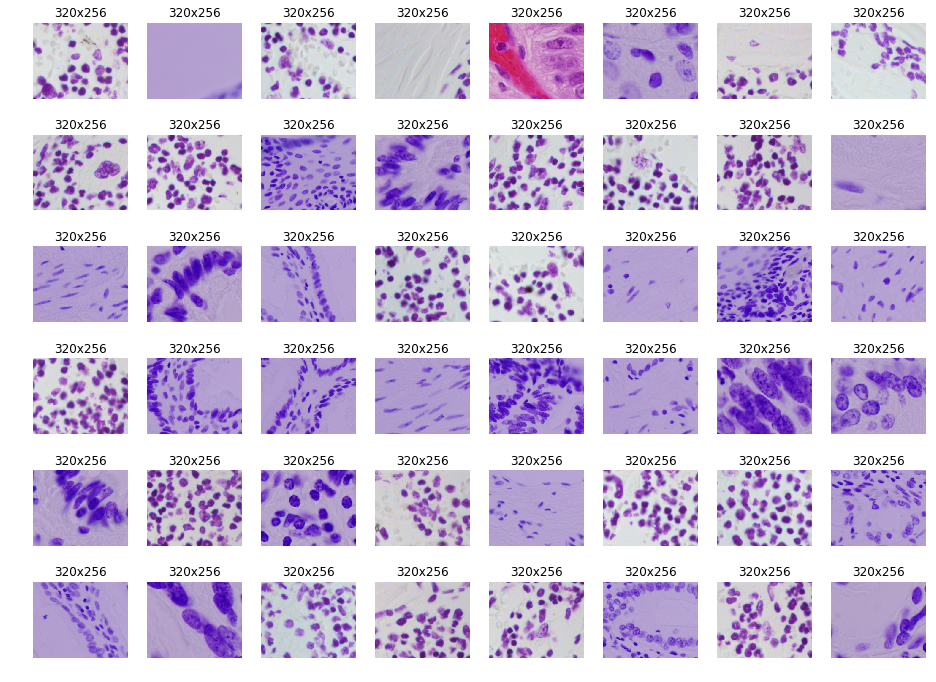

In [14]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 0][IMAGE_ID].values, 6, 8)

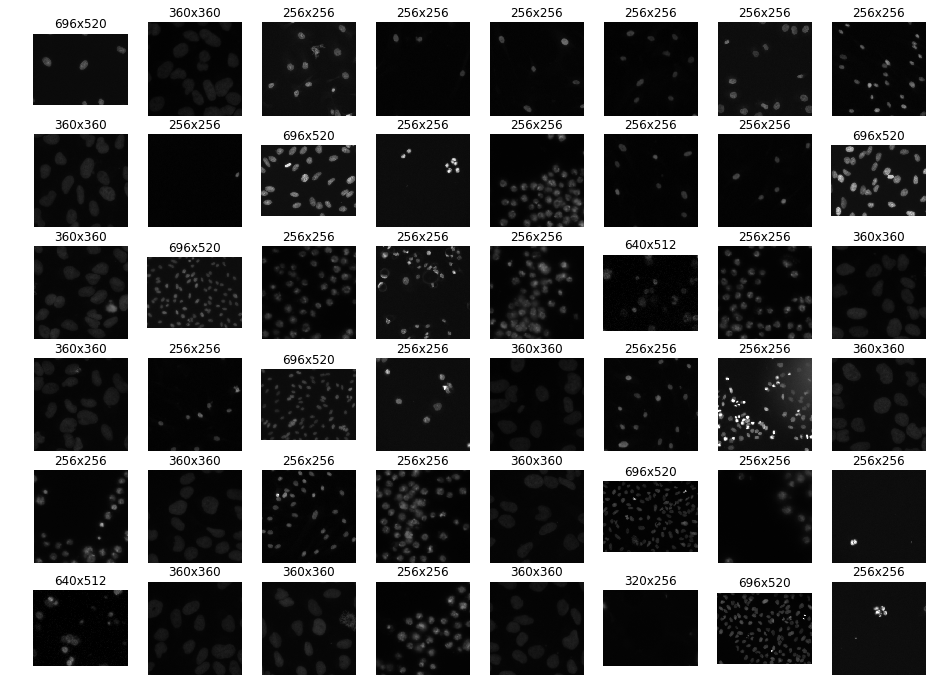

In [15]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 1][IMAGE_ID].values, 6, 8)


In [16]:
P = trainPD.groupby(HSV_CLUSTER)[IMAGE_ID].count().reset_index()
P['Percentage'] = 100*P[IMAGE_ID]/P[IMAGE_ID].sum()
P

,hsv_cluster,image_id,Percentage
0,0,108,16.119403
1,1,546,81.492537
2,2,16,2.388060


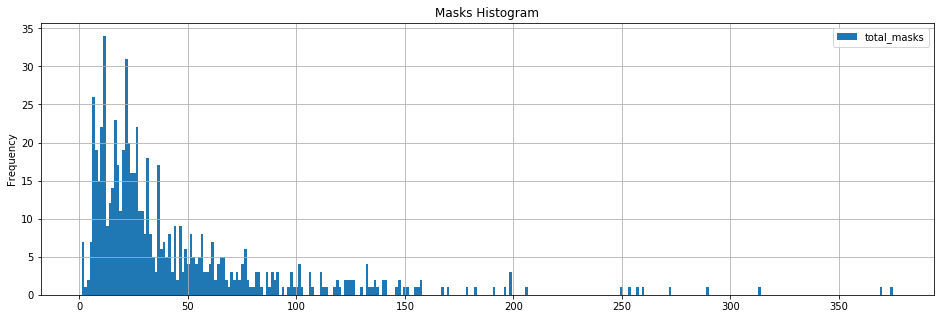

In [17]:
f, ax = plt.subplots(1,1,figsize=(16,5))
r = trainPD.plot(kind="hist", bins=300, y = TOTAL_MASK, ax=ax, grid=True, title="Masks Histogram")

In [18]:
def plot_image_masks(image, labels, num_masks, image_id):
    f, ax = plt.subplots(1,3,figsize=(16,5))
    d = ax[0].axis('off')
    d = ax[0].imshow(image)
    d = ax[0].set_title("\n".join(wrap(image_id, 32)))
    d = ax[1].axis('off')
    d = ax[1].imshow(labels)
    d = ax[1].set_title("masks: %d"%num_masks)
    d = ax[2].axis('off')
    d = ax[2].imshow(image)
    d = ax[2].imshow(labels, alpha=0.5)
    d = ax[2].set_title("both")

In [19]:
def display_image_masks(image_id):
    image, labels, num_masks = read_image_labels(image_id)
    plot_image_masks(image, labels, num_masks, image_id)

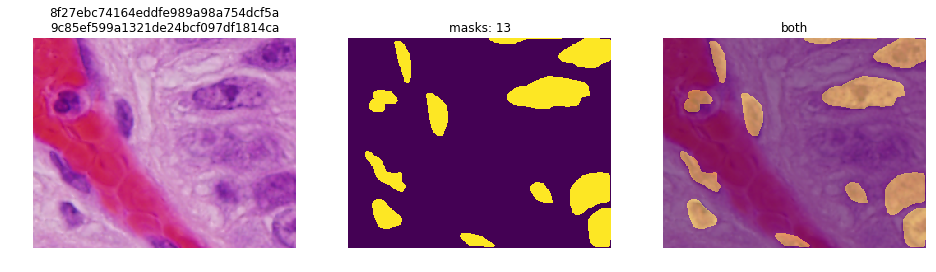

In [20]:
display_image_masks("8f27ebc74164eddfe989a98a754dcf5a9c85ef599a1321de24bcf097df1814ca")

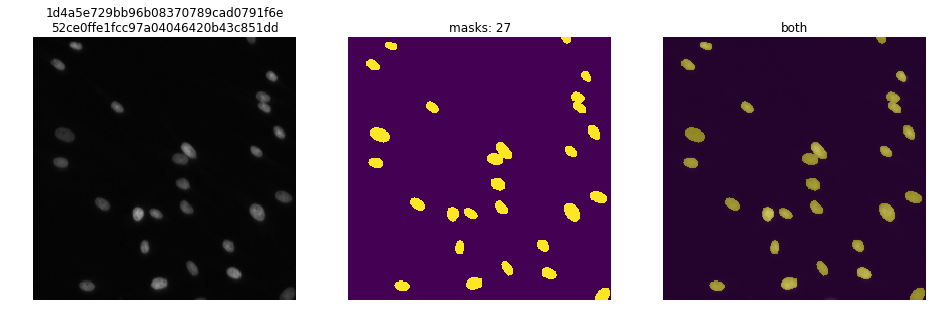

In [21]:
display_image_masks(trainPD[trainPD[TOTAL_MASK] == trainPD[TOTAL_MASK].median()][IMAGE_ID].values[0])

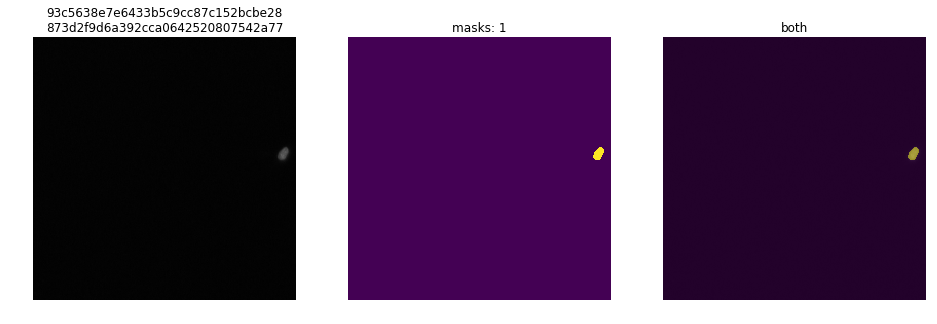

In [22]:
display_image_masks(trainPD[trainPD[TOTAL_MASK] == trainPD[TOTAL_MASK].min()][IMAGE_ID].values[0])

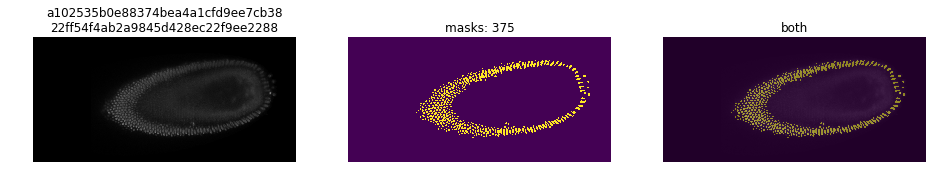

In [23]:
display_image_masks(trainPD[trainPD[TOTAL_MASK] == trainPD[TOTAL_MASK].max()][IMAGE_ID].values[0])